In [1]:
#importine necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import Lambda, Cropping2D, Activation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [2]:
#setting data directory and column names
datadir = "C:\\Users\\MSI\\Desktop\\SDCar"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

In [3]:
#loading data from csv file
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\msi63\Desktop\SDCar\IMG\center_2019_11_13_05_31_36_643.jpg   
1  C:\Users\msi63\Desktop\SDCar\IMG\center_2019_11_13_05_31_36_750.jpg   
2  C:\Users\msi63\Desktop\SDCar\IMG\center_2019_11_13_05_31_36_853.jpg   
3  C:\Users\msi63\Desktop\SDCar\IMG\center_2019_11_13_05_31_36_955.jpg   
4  C:\Users\msi63\Desktop\SDCar\IMG\center_2019_11_13_05_31_37_060.jpg   

                                                                 left  \
0   C:\Users\msi63\Desktop\SDCar\IMG\left_2019_11_13_05_31_36_643.jpg   
1   C:\Users\msi63\Desktop\SDCar\IMG\left_2019_11_13_05_31_36_750.jpg   
2   C:\Users\msi63\Desktop\SDCar\IMG\left_2019_11_13_05_31_36_853.jpg   
3   C:\Users\msi63\Desktop\SDCar\IMG\left_2019_11_13_05_31_36_955.jpg   
4   C:\Users\msi63\Desktop\SDCar\IMG\left_2019_11_13_05_31_37_060.jpg   

                                                                 right  \
0   C:\Users\msi63\Desktop\SDCar\IMG\right_2019_11_13_05_31_36_643.jpg   
1   C:\Users\msi63\Desktop\SDCar\IMG\right_2019_11_13_05_31_36_750.jpg   
2   C:\Users\msi63\Desktop\SDCar\IMG\right_2019_11_13_05_31_36_853.jpg   
3   C:\Users\msi63\Desktop\SDCar\IMG\right_2019_11_13_05_31_36_955.jpg   
4   C:\Users\msi63\Desktop\SDCar\IMG\right_2019_11_13_05_31_37_060.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000018  
1  0.0       0.0       0.0      0.000003  
2  0.0       0.0       0.0      0.000006  
3  0.0       0.0       0.0      0.000011  
4  0.0       0.0       0.0      0.000021

In [4]:
#defining a function to clean column values
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

In [5]:
#applying the function and visualizing data
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2019_11_13_05_31_36_643.jpg  left_2019_11_13_05_31_36_643.jpg   
1  center_2019_11_13_05_31_36_750.jpg  left_2019_11_13_05_31_36_750.jpg   
2  center_2019_11_13_05_31_36_853.jpg  left_2019_11_13_05_31_36_853.jpg   
3  center_2019_11_13_05_31_36_955.jpg  left_2019_11_13_05_31_36_955.jpg   
4  center_2019_11_13_05_31_37_060.jpg  left_2019_11_13_05_31_37_060.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_11_13_05_31_36_643.jpg  0.0       0.0       0.0      0.000018  
1  right_2019_11_13_05_31_36_750.jpg  0.0       0.0       0.0      0.000003  
2  right_2019_11_13_05_31_36_853.jpg  0.0       0.0       0.0      0.000006  
3  right_2019_11_13_05_31_36_955.jpg  0.0       0.0       0.0      0.000011  
4  right_2019_11_13_05_31_37_060.jpg  0.0       0.0       0.0      0.000021

In [6]:
#Visualizing data distribution with histogram
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 10591
removed: 7898
remaining: 2693


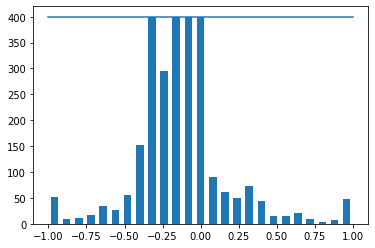

In [7]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
        list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
     
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
#defining a function to load image data
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

center      center_2019_11_13_05_31_37_897.jpg
left        left_2019_11_13_05_31_37_897.jpg  
right       right_2019_11_13_05_31_37_897.jpg 
steering   -0.444477                          
throttle    0                                 
reverse     0                                 
speed       4.58931e-05                       
Name: 12, dtype: object


In [9]:
#loading image data
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [11]:
#dividing data into train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 6463
Valid Samples: 1616


Text(0.5, 1.0, 'Validation set')

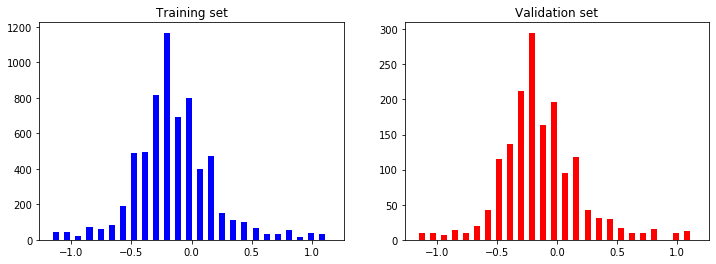

In [12]:
#visualizing train and validation data distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [13]:
#defining a function to zoom image
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

In [14]:
#zooming image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
     
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
     
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
     
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1, 'Zoomed Image')

In [15]:
#defining a function to pan image
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [16]:
#panning image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
     
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
     
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
     
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1, 'Panned Image')

In [17]:
#defining a function to adjust brightness
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [18]:
#adjusting brighness
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1, 'Brightness altered image ')

In [19]:
#defining a function to flip image
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1, 'Flipped Image - Steering Angle:0.4532307')

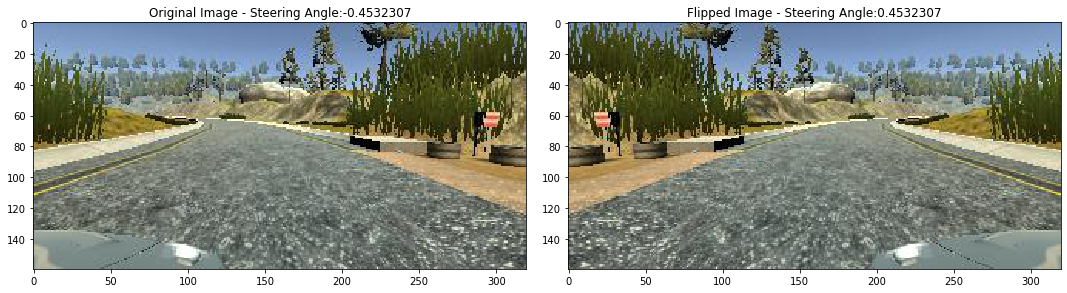

In [20]:
#flipping image
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
     
     
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
     
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
     
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
     
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [21]:
#defining a function to augment image
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
        
    return image, steering_angle

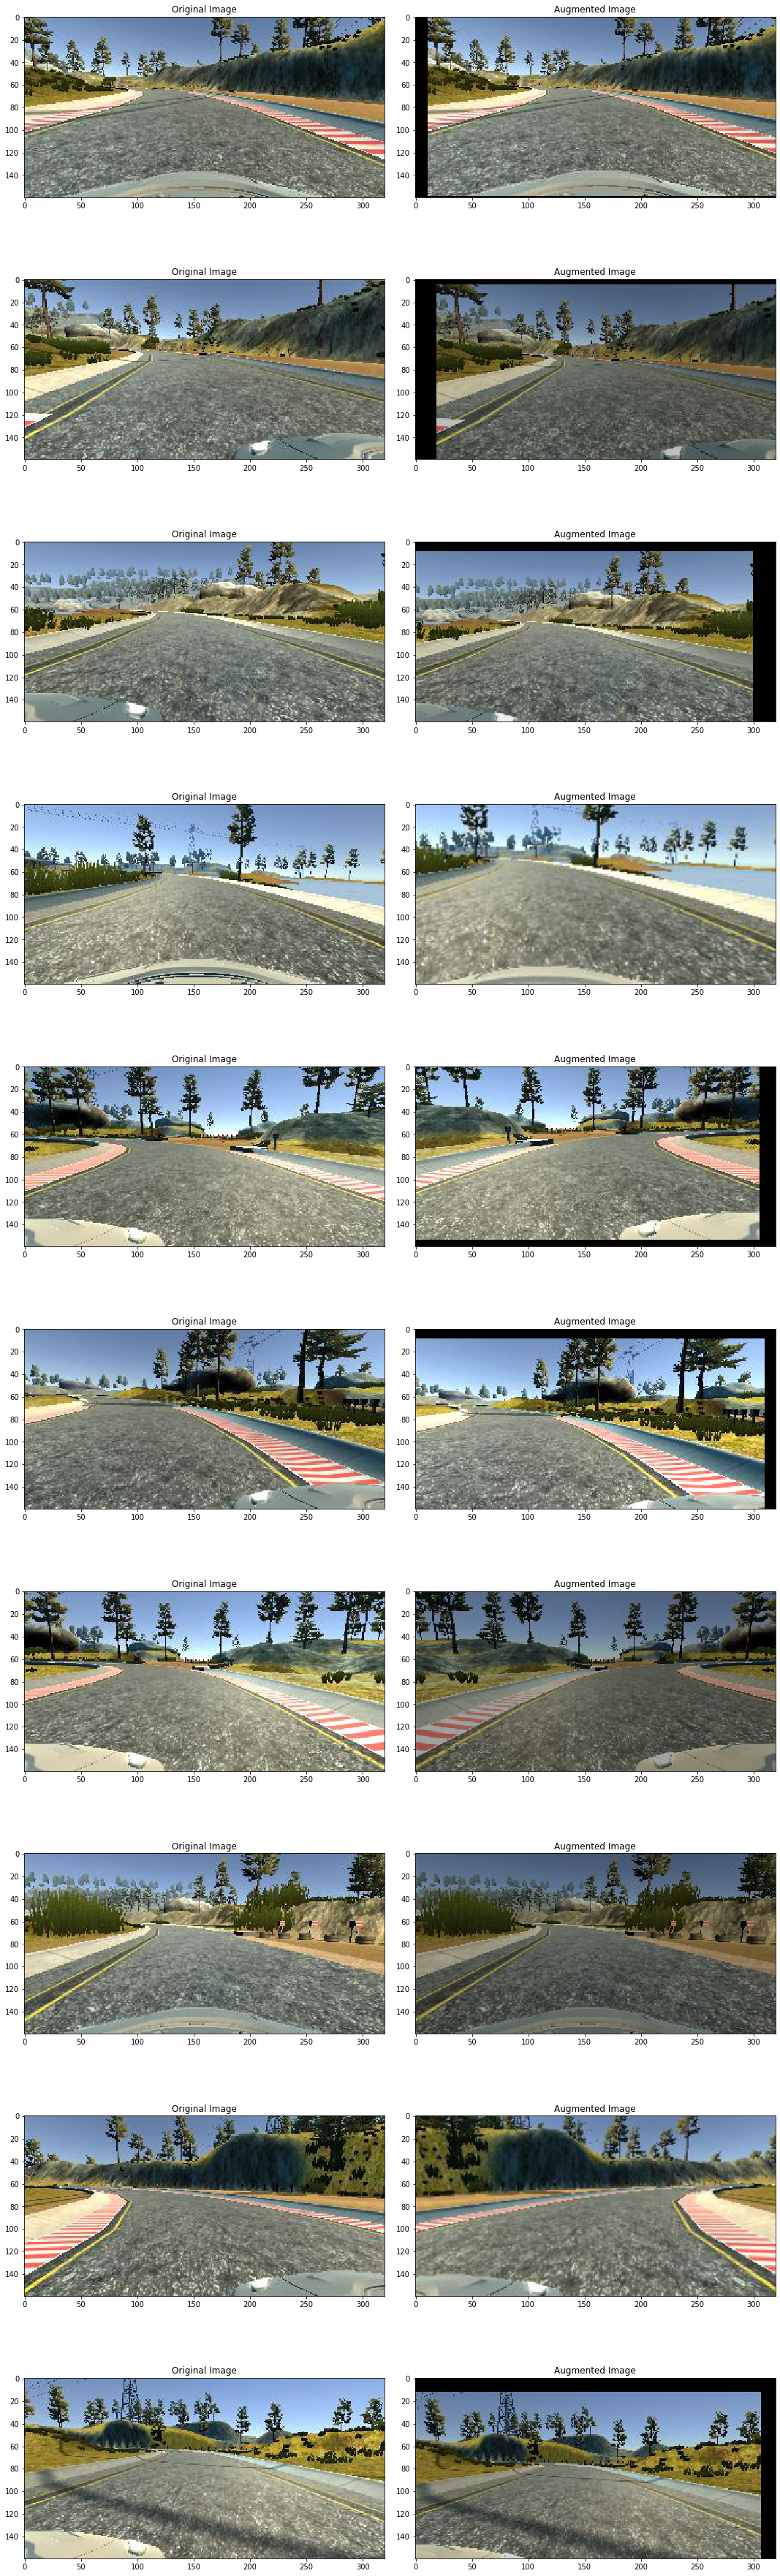

In [22]:
#augmanting images
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [23]:
#defining a function to preprocess images
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (320, 160))
    img = img/255
    return img

Text(0.5, 1, 'Preprocessed Image')

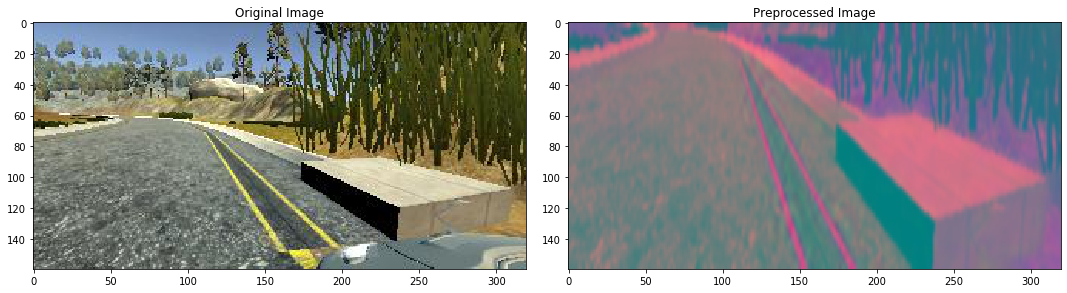

In [24]:
#preprocessing images
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
     
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [25]:
#defining a function to generate batches
def batch_generator(image_paths, steering_ang, batch_size, istraining):
      
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
          
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
         
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
          
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1, 'Validation Image')

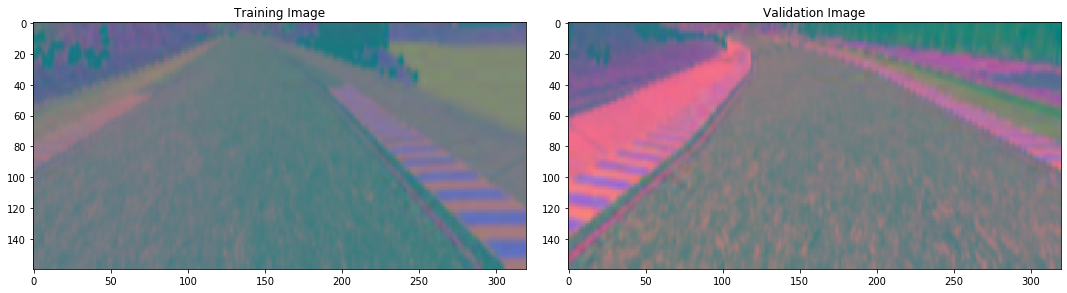

In [26]:
#generating batches
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
     
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
     
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
     
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [27]:
#defining a model
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# trim image to only see section with road
model.add(Cropping2D(cropping=((70,25),(0,0))))           

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Convolution2D(24,5,5,subsample=(2,2)))
model.add(Activation('elu'))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Convolution2D(36,5,5,subsample=(2,2)))
model.add(Activation('elu'))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Convolution2D(48,5,5,subsample=(2,2)))
model.add(Activation('elu'))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64,3,3))
model.add(Activation('elu'))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64,3,3))
model.add(Activation('elu'))

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100))
model.add(Activation('elu'))

#Adding a dropout layer to avoid overfitting. Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50))
model.add(Activation('elu'))


#layer 8- fully connected layer 1
model.add(Dense(10))
model.add(Activation('elu'))

#layer 9- fully connected layer 1
model.add(Dense(1)) #here the final layer will contain one value as this is a regression problem and not classification


# the output is the steering angle
# using mean squared error loss function is the right choice for this regression problem
# adam optimizer is used here
model.compile(loss='mse',optimizer='adam')

C:\Users\MSI\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\MSI\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2))`
  
C:\Users\MSI\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2))`
C:\Users\MSI\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
C:\Users\MSI\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
activation_1 (Activation)    (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 37, 48)        

In [30]:
#Training model
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                      steps_per_epoch=300, 
                                      epochs=10,
                                      validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                      validation_steps=200,
                                      verbose=1,
                                      shuffle = 1)


Epoch 1/10
300/300 [==============================] - 254s 845ms/step - loss: 0.1774 - val_loss: 0.1045
Epoch 2/10
300/300 [==============================] - 162s 539ms/step - loss: 0.1262 - val_loss: 0.1091
Epoch 3/10
300/300 [==============================] - 249s 828ms/step - loss: 0.1262 - val_loss: 0.1378
Epoch 4/10
300/300 [==============================] - 338s 1s/step - loss: 0.1296 - val_loss: 0.1114
Epoch 5/10
300/300 [==============================] - 279s 931ms/step - loss: 0.1294 - val_loss: 0.1171
Epoch 6/10
300/300 [==============================] - 249s 830ms/step - loss: 0.1281 - val_loss: 0.0929
Epoch 7/10
300/300 [==============================] - 156s 521ms/step - loss: 0.1281 - val_loss: 0.1563
Epoch 8/10
300/300 [==============================] - 157s 523ms/step - loss: 0.1286 - val_loss: 0.1103
Epoch 9/10
300/300 [==============================] - 155s 516ms/step - loss: 0.1248 - val_loss: 0.1296
Epoch 10/10
300/300 [==============================] - 155s 515ms/

Text(0.5, 0, 'Epoch')

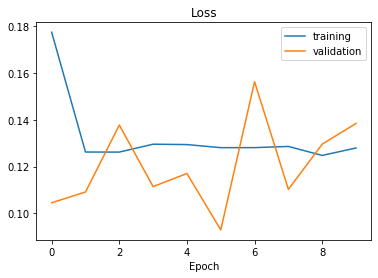

In [31]:
#Visualizing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
#saving model
model.save('E:\\model.h5')